In [526]:
import numpy as np
import pandas as pd
import yfinance as yf
from pylab import mpl
import matplotlib.pyplot as plt
from ysk_quantlib import *

plt.style.use('seaborn-v0_8-paper')
mpl.rcParams['font.serif'] = 'Times'
%matplotlib inline

In [527]:
data = pd.read_csv('tsla_1min.csv', sep=',')

data = data.set_index('timestamp')

data

,open,high,low,close,volume
timestamp,,,,,
2025-04-01 04:00:00,264.00,265.50,262.270,265.16,50312
2025-04-01 04:01:00,265.20,267.06,265.010,266.52,52063
2025-04-01 04:02:00,266.54,269.10,266.540,268.79,93101
2025-04-01 04:03:00,268.68,269.45,267.970,269.40,89172
2025-04-01 04:04:00,269.40,269.49,268.350,268.41,85783
...,...,...,...,...,...
2025-06-30 19:55:00,311.27,311.29,311.160,311.24,12101
2025-06-30 19:56:00,311.26,311.33,311.160,311.24,10091
2025-06-30 19:57:00,311.24,311.30,311.150,311.17,12476


In [528]:
figs=(24,9)

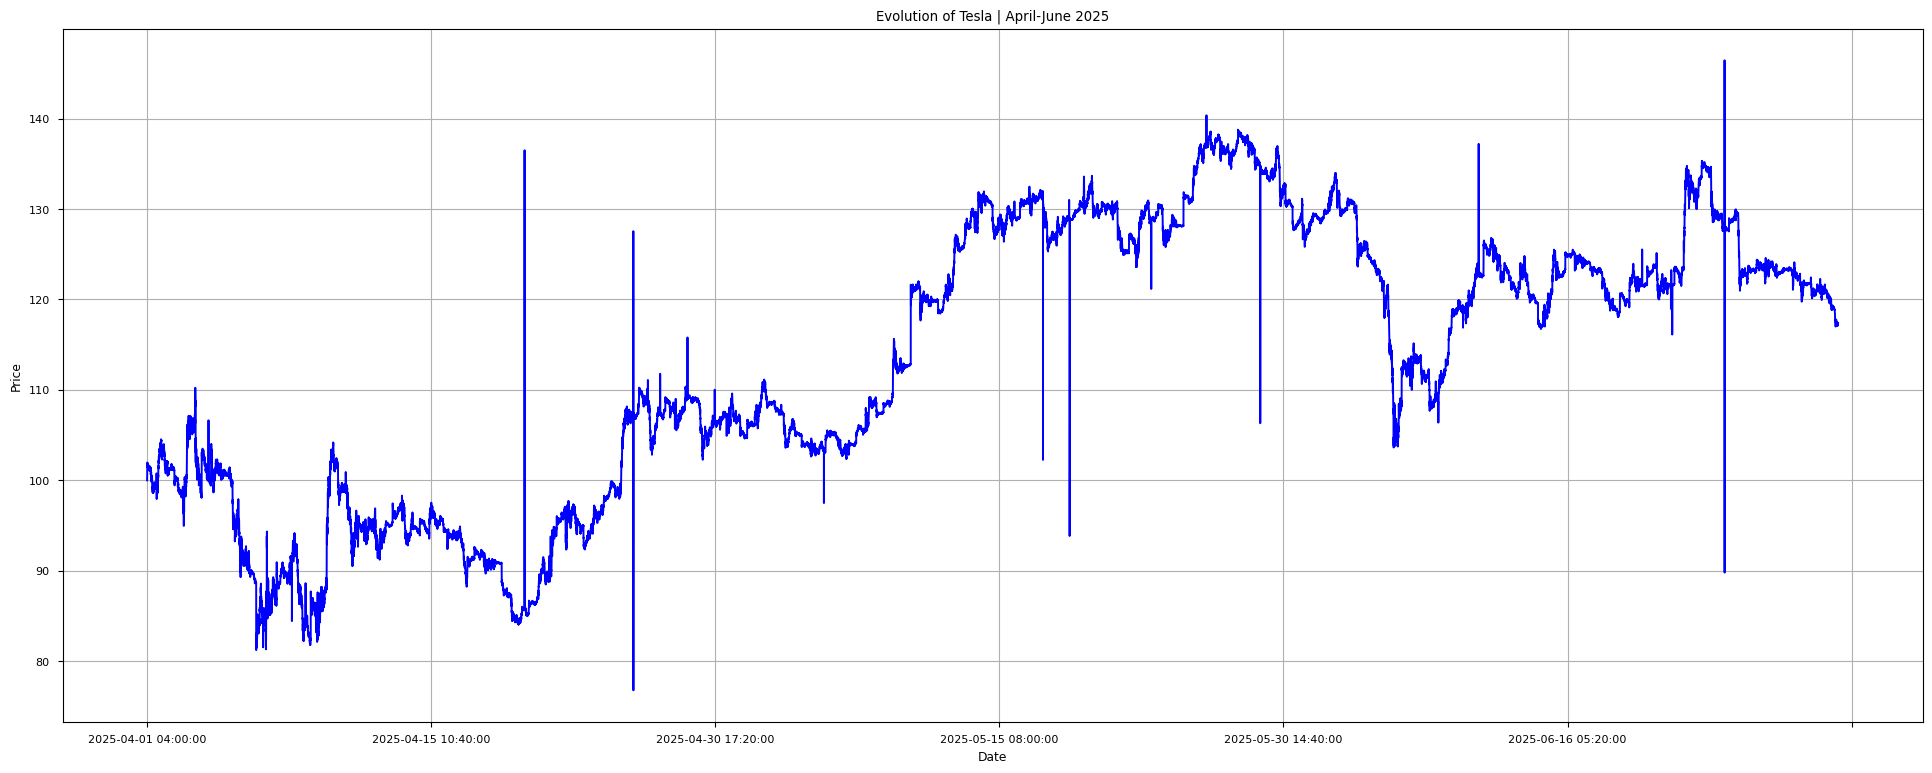

In [529]:
def normalize(x):
    return x['close'] * 100 / x['close'].iloc[0]

normalize(data).plot(figsize=figs, color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Evolution of Tesla | April-June 2025', loc='center')
plt.grid(True)
plt.show()

In [530]:
prices = data['close']

returns = prices.pct_change().dropna()

returns.describe(include="all")

count    59519.000000
mean         0.000018
std          0.005646
min         -0.372535
25%         -0.000474
50%          0.000000
75%          0.000475
max          0.592146
Name: close, dtype: float64

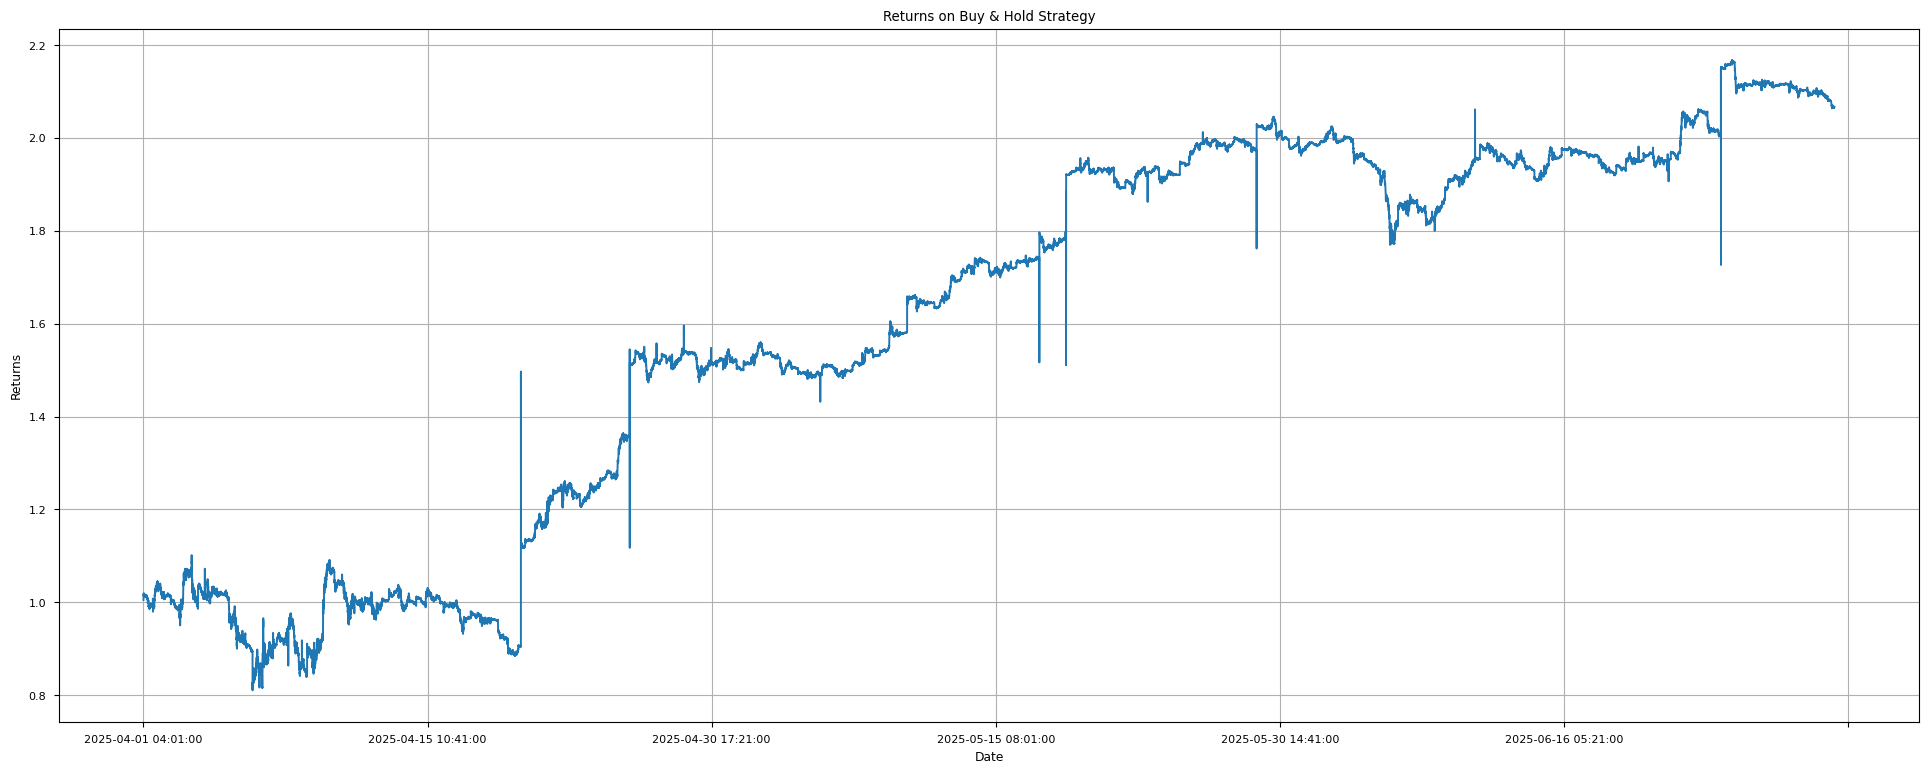

In [531]:
(returns.cumsum() + 1).plot(figsize=figs)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns on Buy & Hold Strategy')
plt.grid(True)
plt.show()

In [532]:
vol = data['close'].rolling(60).std()

alpha, beta, theta = .5, .3, .15

np.random.seed = 1

In [ ]:
# The idea of a customized EWMA (which is more like an AR(3)) with a random component seems interesting, so I'll stick with that.

def ewma(x, alpha = 0.25, beta=0.25, theta = 0.25):
    y = np.zeros_like(x)
    for i in range(0,3):
        y[i] = x[i]
    for i in range(3, len(x)):
        y[i] = alpha * x[i] + beta * y[i-1] + theta * y[i-2] + (1-alpha-beta-theta) * y[i-3] + np.random.random()
    return y

In [534]:
data['EWMA'] = ewma(data['close'], alpha, beta, theta)

C:\Users\houss\AppData\Local\Temp\ipykernel_1972\702148824.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y[i] = x[i]
C:\Users\houss\AppData\Local\Temp\ipykernel_1972\702148824.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y[i] = alpha * x[i] + beta * y[i-1] + theta * y[i-2] + (1-alpha-beta-theta) * y[i-3] + np.random.random()


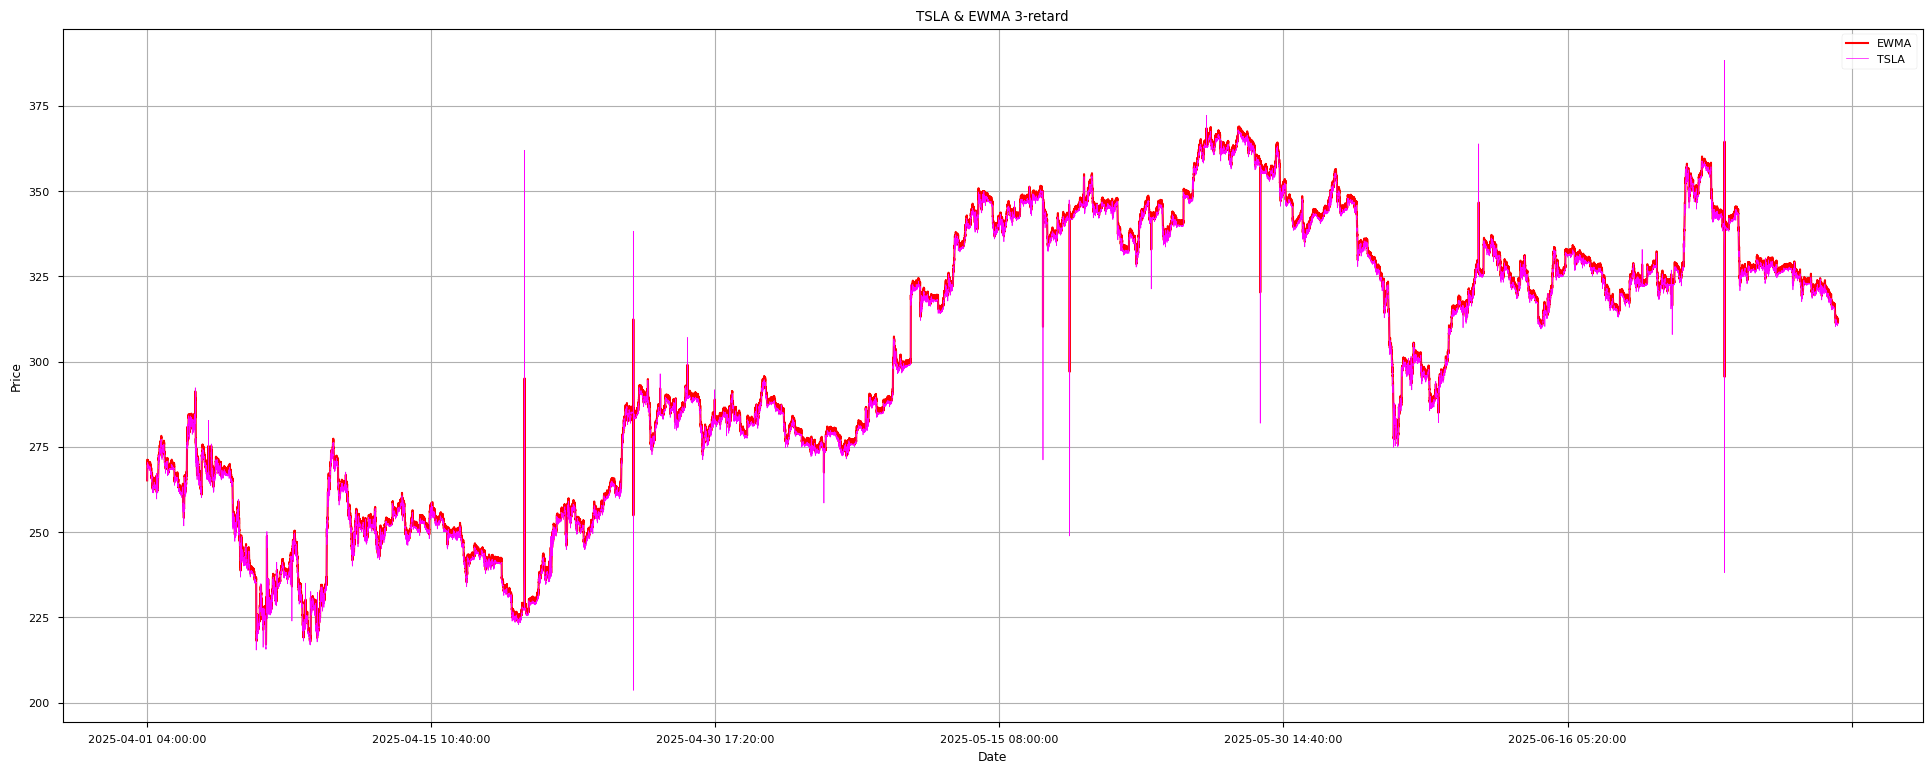

In [535]:
data['EWMA'].plot(figsize=figs, label='EWMA', color='red', lw=1.5);
plt.plot(prices, label='TSLA', color='magenta', lw=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TSLA & EWMA 3-retard')
plt.grid(True)
plt.legend(loc=0)
plt.show()

It's really difficult to see something on this graph, but it really shows that the EWMA is a good approximation of the price. We can see that the EWMA is a bit more smooth than the price, but it still follows the price quite well.

In [536]:
data['zscore'] = (data['close'] - data['EWMA']) / data['close'].rolling(60).std()

n = 1

data['volatility'] = vol

vol_level = 5

data['signal'] = np.where((data['zscore'] < n) & (data['volatility'] < vol_level), 1, np.where((data['zscore'] > -n) & (data['volatility'] < vol_level), -1, 0))

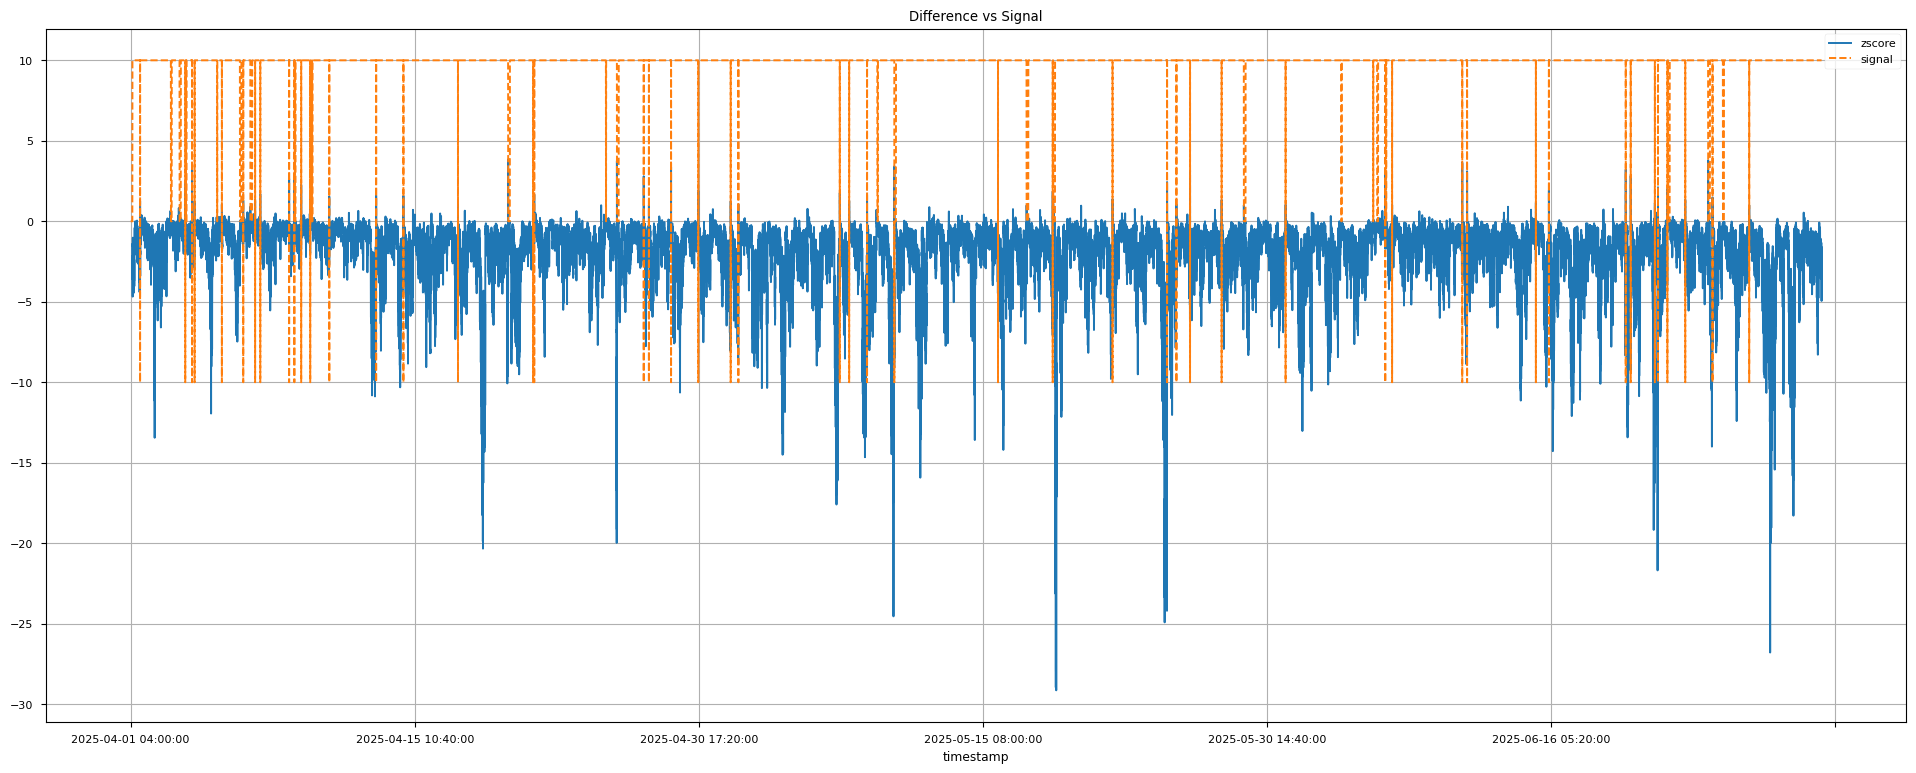

In [ ]:
data['zscore'].plot(figsize=figs)
(10*data['signal']).plot(figsize=figs, linestyle='--')
plt.title("Z-score vs Signal")
plt.grid(True)
plt.legend()
plt.show()

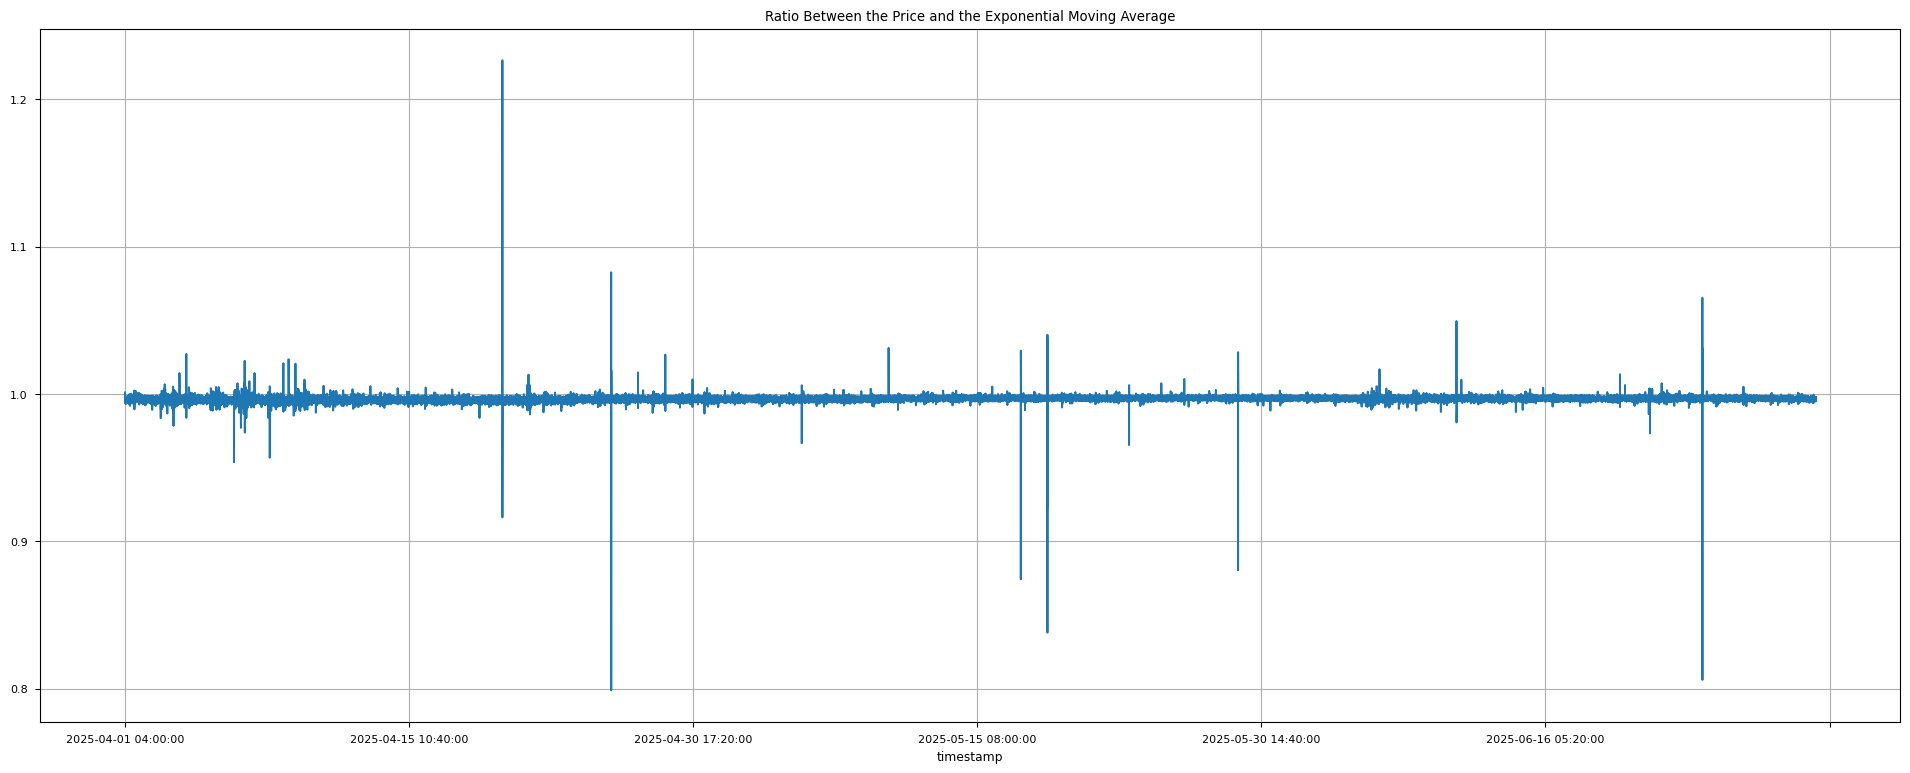

In [538]:
(data["close"]/data['EWMA']).plot(figsize=figs)
plt.title("Ratio Between the Price and the Exponential Moving Average")
plt.grid(True)
plt.show()

In [539]:
# Frais de transaction (ex. 0.1% = 0.001 par trade)
fee = 0.001

# Détection des changements de position (changement de signal)
data['trade_flag'] = data['signal'].diff().abs() > 0

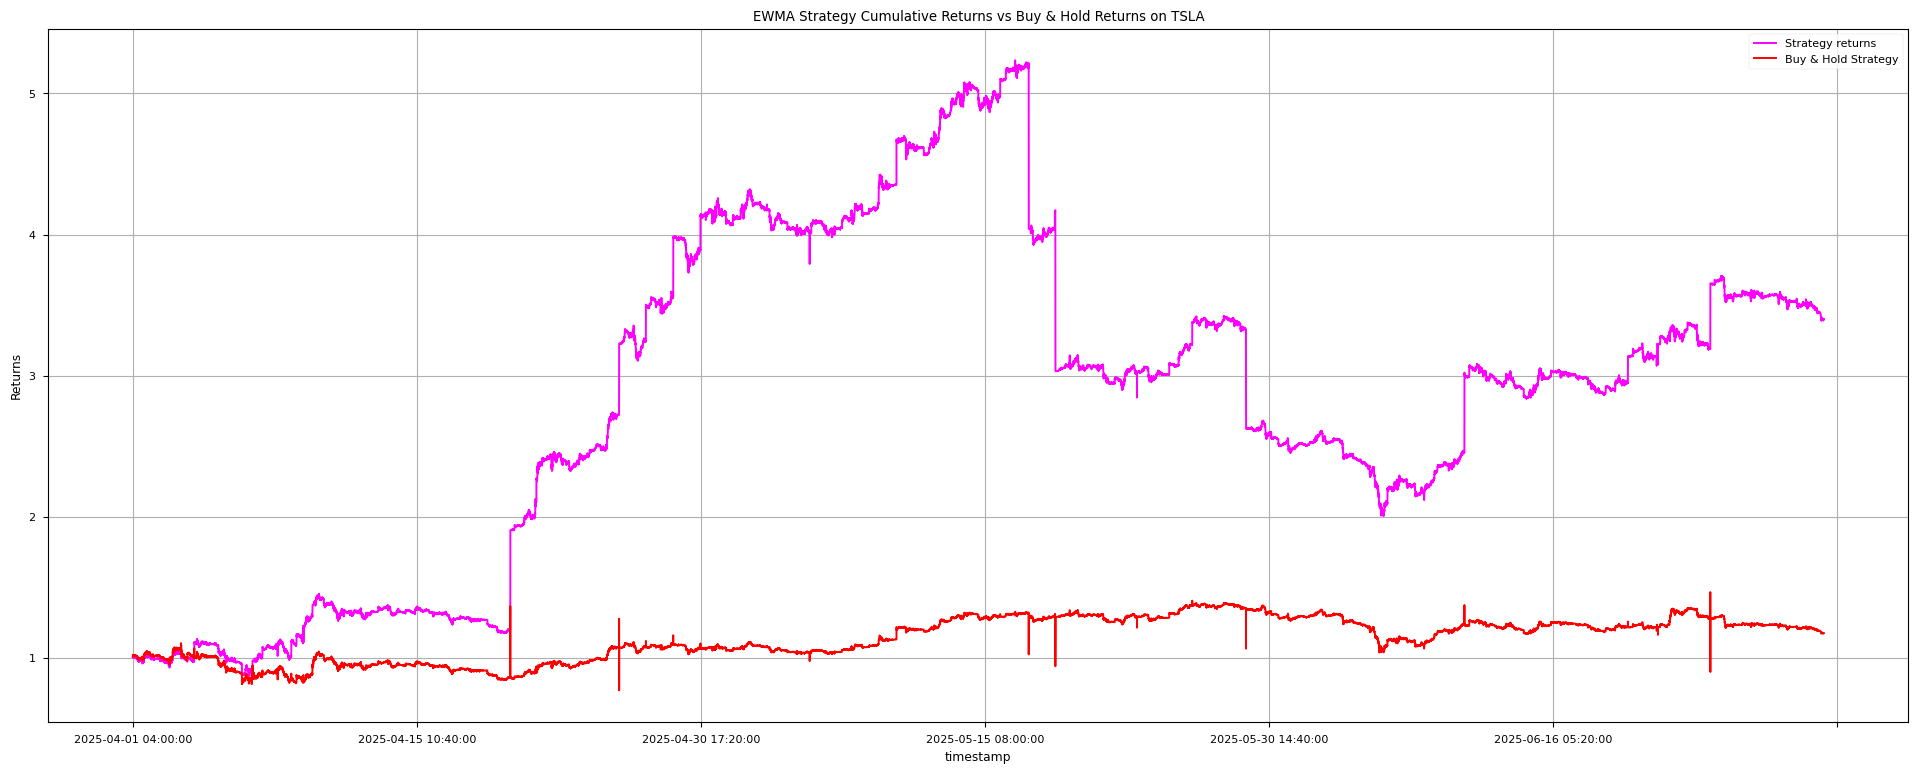

In [548]:
data['strategy_returns'] = (data['signal'].shift(1) * returns) - data['trade_flag'] * fee * data['close'].pct_change().abs()

data['cumulative_returns'] = (1 + data['strategy_returns']).cumprod()

data['bh_returns'] = (1 + returns).cumprod()

data['cumulative_returns'].plot(figsize = figs, label = 'Strategy returns', color = 'magenta')
plt.plot(data['bh_returns'], label = 'Buy & Hold Strategy', color = 'red')
plt.ylabel('Returns')
plt.title("EWMA Strategy Cumulative Returns vs Buy & Hold Returns on TSLA")
plt.grid(True)
plt.legend(loc=0)
plt.show()

Honestly, the returns are really high, I don't really understand how that's possible with the fees, and I ran a test with NVDA over the same period and got similar results. The strategy seems to perfectly reflect the asset's trend until mid-May, it starts to become a little inaccurate, but it really gives good results overall. It remains to be seen in a real-world test, but it's promising and doesn't fall into the trap of overfitting.

In [541]:
def sharpe_ratio(series, r_f=0.02, freq=252*390):  # 252 jours de bourse × 390 minutes/jour
    excess_ret = series.mean() - r_f / freq
    return (excess_ret / series.std()) * np.sqrt(freq)

In [542]:
sh_1 = sharpe_ratio(data.strategy_returns)
sh_1_bh = sharpe_ratio(returns)

print('Sharpe ratio of the EMA strategy:', sh_1)
print('Sharpe ratio of the B&H strategy:', sh_1_bh)

Sharpe ratio of the EMA strategy: 2.2556532167635286
Sharpe ratio of the B&H strategy: 0.983878726863085


In [546]:
drawdown = data.cumulative_returns / data.cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()

drawdown_bh = data.bh_returns / data.bh_returns.cummax() - 1
max_drawdown_bh = drawdown_bh.min()

print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Max Drawdown B&H: {max_drawdown_bh:.2%}")

Max Drawdown: -61.71%
Max Drawdown B&H: -43.75%
